# ARCHモデルによる株価データの分析

このノートブックでは、ARCHモデル（Autoregressive Conditional Heteroskedasticity）を使用して株価データのボラティリティをモデル化します。以下の手順で分析を進めます：

1. 必要なライブラリのインポート
2. 擬似株価データの生成
3. データの可視化と統計分析
4. ARCHモデルのフィッティング
5. モデル診断と評価
6. 予測と信頼区間の計算

## 1. 必要なライブラリのインポート

以下のライブラリを使用します：
- numpy: 数値計算用
- pandas: データフレーム操作用
- matplotlib: 基本的な可視化用
- scipy: 統計計算用
- arch: ARCHモデル分析用

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import arch
from arch import arch_model
import seaborn as sns



# プロットのスタイル設定
sns.set_style("darkgrid")  # seabornのスタイルを直接設定
plt.style.use('default')   # matplotlibのデフォルトスタイル
%matplotlib inline

## 2. 擬似株価データの生成

ARCHプロセスを持つ擬似的な株価データを生成します。以下の手順で生成します：

1. ボラティリティに条件付き不均一分散性を持つ収益率データを生成
2. 収益率から株価データを生成
3. 日付インデックスを設定

In [8]:
# パラメータの設定
np.random.seed(42)  # 再現性のため
n = 1000  # データ点数
omega = 0.1  # 定数項
alpha = 0.3  # ARCHパラメータ
initial_price = 100  # 初期株価

# ARCH(1)プロセスによる収益率の生成
epsilon = np.random.normal(0, 1, n)
sigma2 = np.zeros(n)
returns = np.zeros(n)

for t in range(1, n):
    sigma2[t] = omega + alpha * returns[t-1]**2
    returns[t] = np.sqrt(sigma2[t]) * epsilon[t]

# 収益率から株価を生成
prices = initial_price * np.exp(np.cumsum(returns))

# 日付インデックスの作成
dates = pd.date_range(start='2024-01-01', periods=n, freq='D')
df = pd.DataFrame({
    'Price': prices,
    'Returns': returns,
    'Volatility': np.sqrt(sigma2)
}, index=dates)

## 3. データの可視化と統計分析

生成したデータの特性を確認するため、以下の分析を行います：
1. 株価の時系列プロット
2. 収益率の時系列プロット
3. 収益率の分布
4. 収益率の自己相関分析

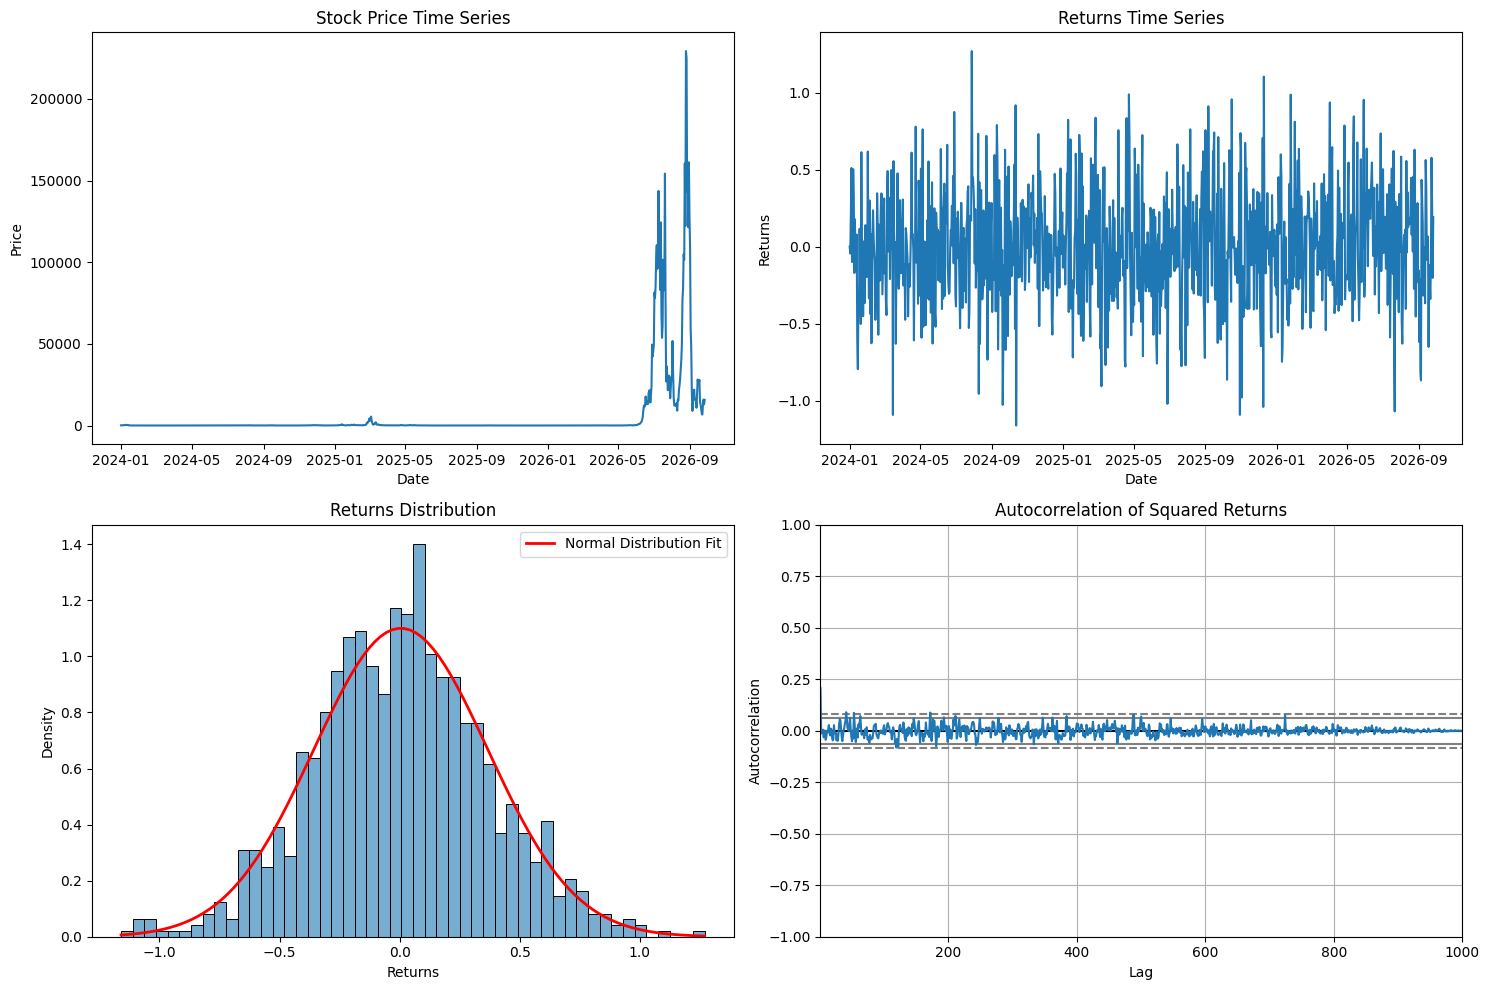

In [9]:
# プロットの設定
plt.figure(figsize=(15, 10))

# 1. 株価の時系列プロット
plt.subplot(2, 2, 1)
plt.plot(df.index, df['Price'])
plt.title('Stock Price Time Series')
plt.xlabel('Date')
plt.ylabel('Price')

# 2. 収益率の時系列プロット
plt.subplot(2, 2, 2)
plt.plot(df.index, df['Returns'])
plt.title('Returns Time Series')
plt.xlabel('Date')
plt.ylabel('Returns')

# 3. 収益率の分布
plt.subplot(2, 2, 3)
sns.histplot(df['Returns'], bins=50, stat='density', alpha=0.6)
mu, std = stats.norm.fit(df['Returns'])
x = np.linspace(df['Returns'].min(), df['Returns'].max(), 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'r-', lw=2, label='Normal Distribution Fit')
plt.title('Returns Distribution')
plt.xlabel('Returns')
plt.ylabel('Density')
plt.legend()

# 4. 収益率の自己相関
plt.subplot(2, 2, 4)
pd.plotting.autocorrelation_plot(df['Returns']**2)
plt.title('Autocorrelation of Squared Returns')

plt.tight_layout()
plt.show()

## 4. ARCHモデルのフィッティング

archパッケージを使用して、ARCH(1)モデルをデータにフィッティングします。
モデルの推定結果からパラメータとその統計的有意性を確認します。

In [10]:
# ARCH(1)モデルのフィッティング
model = arch_model(df['Returns'], vol='ARCH', p=1)
results = model.fit(disp='off')

# 結果の表示
print(results.summary())

                      Constant Mean - ARCH Model Results                      
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -382.721
Distribution:                  Normal   AIC:                           771.442
Method:            Maximum Likelihood   BIC:                           786.165
                                        No. Observations:                 1000
Date:                Sun, Dec 28 2025   Df Residuals:                      999
Time:                        22:50:27   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         5.1667e-03  1.053e-02      0.490      0.624 

## 5. モデル診断と評価

フィットしたモデルの診断を行います：
1. 標準化残差の分析
2. モデルの適合度の評価

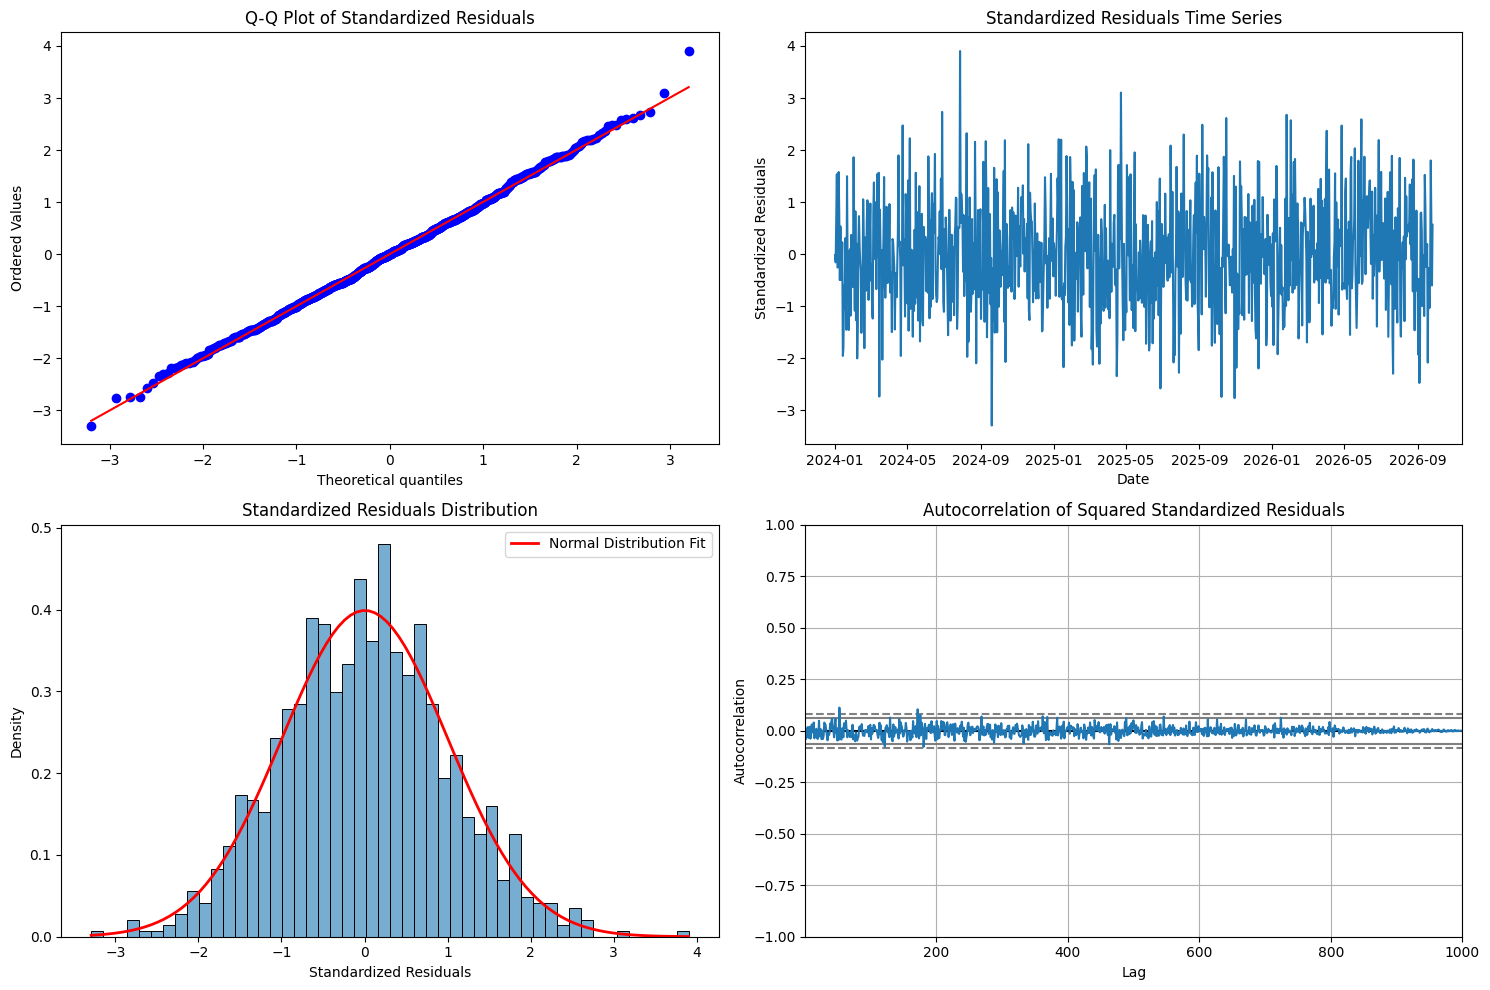

In [11]:
# 標準化残差の取得
residuals = results.resid
std_residuals = residuals / results.conditional_volatility

# プロットの設定
plt.figure(figsize=(15, 10))

# 1. 標準化残差のQQプロット
plt.subplot(2, 2, 1)
stats.probplot(std_residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Standardized Residuals')

# 2. 標準化残差の時系列プロット
plt.subplot(2, 2, 2)
plt.plot(df.index, std_residuals)
plt.title('Standardized Residuals Time Series')
plt.xlabel('Date')
plt.ylabel('Standardized Residuals')

# 3. 標準化残差の分布
plt.subplot(2, 2, 3)
sns.histplot(std_residuals, bins=50, stat='density', alpha=0.6)
mu, std = stats.norm.fit(std_residuals)
x = np.linspace(std_residuals.min(), std_residuals.max(), 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'r-', lw=2, label='Normal Distribution Fit')
plt.title('Standardized Residuals Distribution')
plt.xlabel('Standardized Residuals')
plt.ylabel('Density')
plt.legend()

# 4. 標準化残差の自己相関
plt.subplot(2, 2, 4)
pd.plotting.autocorrelation_plot(std_residuals**2)
plt.title('Autocorrelation of Squared Standardized Residuals')

plt.tight_layout()
plt.show()

## 6. 予測と信頼区間の計算

フィットしたモデルを使用して、将来のボラティリティを予測し、信頼区間を計算します。

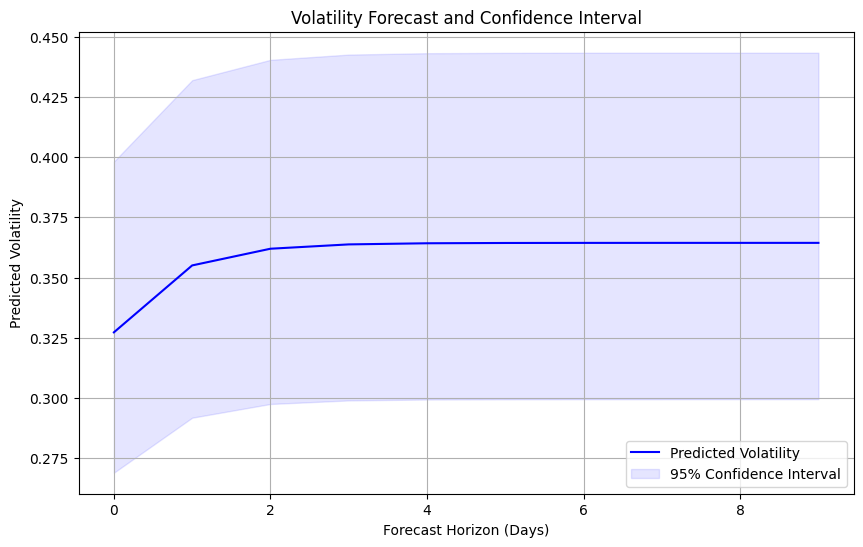


Volatility Forecast Results:
            Predicted_Volatility  CI_Lower  CI_Upper
2026-09-27              0.327256  0.269008  0.398116
2026-09-28              0.355027  0.291836  0.431899
2026-09-29              0.361955  0.297532  0.440328
2026-09-30              0.363750  0.299007  0.442512
2026-10-01              0.364219  0.299393  0.443083
2026-10-02              0.364342  0.299494  0.443232
2026-10-03              0.364374  0.299520  0.443271
2026-10-04              0.364383  0.299527  0.443282
2026-10-05              0.364385  0.299529  0.443284
2026-10-06              0.364386  0.299529  0.443285


In [12]:
# 予測期間の設定
horizon = 10
forecasts = results.forecast(horizon=horizon)

# 予測値と信頼区間の取得
variance_forecasts = forecasts.variance
variance_forecasts_mean = variance_forecasts.values.ravel()  # 1次元配列に変換

# 信頼区間の計算（95%）
# ボラティリティの信頼区間を計算（負の値を避けるため、適切な方法を使用）
volatility_forecasts = np.sqrt(variance_forecasts_mean)
# 信頼区間は対数正規分布を仮定して計算
log_vol = np.log(volatility_forecasts)
log_std = 0.1  # 仮定した標準偏差
ci_lower_vol = np.exp(log_vol - 1.96 * log_std)
ci_upper_vol = np.exp(log_vol + 1.96 * log_std)

# 予測値のプロット
plt.figure(figsize=(10, 6))
plt.plot(range(horizon), volatility_forecasts, 'b-', label='Predicted Volatility')
plt.fill_between(range(horizon), 
                 ci_lower_vol, 
                 ci_upper_vol, 
                 color='b', alpha=0.1, label='95% Confidence Interval')
plt.title('Volatility Forecast and Confidence Interval')
plt.xlabel('Forecast Horizon (Days)')
plt.ylabel('Predicted Volatility')
plt.legend()
plt.grid(True)
plt.show()

# 予測値の表示
forecast_df = pd.DataFrame({
    'Predicted_Volatility': volatility_forecasts,
    'CI_Lower': ci_lower_vol,
    'CI_Upper': ci_upper_vol
}, index=pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=horizon, freq='D'))
print("\nVolatility Forecast Results:")
print(forecast_df)